In [3]:
import pandas as pd
import csv
import numpy as np
import os
import datasets
from datasets import Dataset, DatasetDict
from functools import lru_cache
from torch import nn
import math

/Users/anyahabana/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anyahabana/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Set

In [46]:
df = pd.read_csv('../Data Preprocessing/Out.csv')
df.tail(10)
df.columns = ['Series', 'start', 'Altitude', 'Humidity', 'Temperature', 'Time',
       'Day', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3', 'Latitude',
       'Longitude', 'Lat Diff', 'Long Diff', 'Distance', 'IsStation',
       'IsCharging', 'Cum Distance', 'Next Station Lat', 'Next Station Long',
       'Abs Distance', 'Percent Distance', 'Prev Station Lat',
       'Prev Station Long', 'Prev Abs Distance', 'Prev Cum Distance',
       'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex',
       'Previous Time to Loyola House of Studies',
       'Previous Time to Grade School', 'Previous Time to Gate 2.5',
       'Previous Time to Leong Hall', 'Next Time to Xavier Hall',
       'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies',
       'Next Time to Grade School', 'Next Time to Gate 2.5',
       'Next Time to Leong Hall', 'Encoded Day', 'Encoded Station',
       'Encoded Prev Station', 'Encoded Next Station']
# df.drop(columns=['Datetime'], inplace=True)

df['Series'] = df['Series'] + 1
df


,Series,start,Altitude,Humidity,Temperature,Time,Day,Hour_of_Day,IsEJeep1,IsEJeep2,...,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall,Encoded Day,Encoded Station,Encoded Prev Station,Encoded Next Station
0,1,2023-10-23 17:12:39,79.0,82.500000,29.299999,17:12:39,23.0,17.0,1,0,...,06:12:33,06:41:23,17:24:22,17:30:29,17:16:30,17:21:38,1,8,8,1
1,2,2023-10-23 17:12:40,78.7,82.500000,29.299999,17:12:40,23.0,17.0,1,0,...,06:12:33,06:41:23,17:24:22,17:30:29,17:34:36,17:21:38,1,0,8,1
2,3,2023-10-23 17:12:41,78.4,82.500000,29.299999,17:12:41,23.0,17.0,1,0,...,06:12:33,06:41:23,17:24:22,17:30:29,17:34:36,17:21:38,1,0,8,1
3,4,2023-10-23 17:12:42,78.0,82.500000,29.299999,17:12:42,23.0,17.0,1,0,...,06:12:33,06:41:23,17:24:22,17:30:29,17:34:36,17:21:38,1,0,8,1
4,5,2023-10-23 17:12:43,77.7,82.500000,29.299999,17:12:43,23.0,17.0,1,0,...,06:12:33,06:41:23,17:24:22,17:30:29,17:34:36,17:21:38,1,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482694,482695,2023-11-12 09:53:23,75.1,80.400002,30.799999,09:53:23,12.0,9.0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,7,5,4,5
482695,482696,2023-11-12 09:53:24,75.5,80.400002,30.799999,09:53:24,12.0,9.0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,7,5,4,5
482696,482697,2023-11-12 09:53:25,75.3,80.400002,30.799999,09:53:25,12.0,9.0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,7,5,4,5
482697,482698,2023-11-12 09:53:26,74.9,80.400002,30.799999,09:53:26,12.0,9.0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,7,5,4,5


In [48]:
# make target column
df['target'] = df.apply(lambda x: [x['Next Time to Xavier Hall'], x['Next Time to Fine Arts Annex'], x['Next Time to Loyola House of Studies'], x['Next Time to Grade School'], x['Next Time to Gate 2.5'], x['Next Time to Leong Hall']], axis=1)
df.drop(columns=['Next Time to Xavier Hall', 'Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall'], inplace=True)

In [50]:
# split data into train-test set
train = df[df['Day'] < 16]
test = df[df['Day'] >= 16]
validation = df[df['Day'] < 17]

# reset index
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)

# check shape
train.shape, test.shape, validation.shape

((312017, 38), (170682, 38), (396188, 38))

In [51]:
train_set = Dataset.from_pandas(train)
test_set = Dataset.from_pandas(test)
validation_set = Dataset.from_pandas(validation)

dataset = DatasetDict()

dataset['train'] = train_set
dataset['test'] = test_set
dataset['validation'] = validation_set



dataset

DatasetDict({
    train: Dataset({
        features: ['Series', 'start', 'Altitude', 'Humidity', 'Temperature', 'Time', 'Day', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3', 'Latitude', 'Longitude', 'Lat Diff', 'Long Diff', 'Distance', 'IsStation', 'IsCharging', 'Cum Distance', 'Next Station Lat', 'Next Station Long', 'Abs Distance', 'Percent Distance', 'Prev Station Lat', 'Prev Station Long', 'Prev Abs Distance', 'Prev Cum Distance', 'Previous Time to Xavier Hall', 'Previous Time to Fine Arts Annex', 'Previous Time to Loyola House of Studies', 'Previous Time to Grade School', 'Previous Time to Gate 2.5', 'Previous Time to Leong Hall', 'Encoded Day', 'Encoded Station', 'Encoded Prev Station', 'Encoded Next Station', 'target'],
        num_rows: 312017
    })
    test: Dataset({
        features: ['Series', 'start', 'Altitude', 'Humidity', 'Temperature', 'Time', 'Day', 'Hour_of_Day', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3', 'Latitude', 'Longitude', 'Lat Diff', 'Long Diff', 'Distance', 'I

# Multivariate Probabilistic Time Series Forecasting with Informer
https://huggingface.co/blog/informer

In [7]:
def probsparse_attention(query_states, key_states, value_states, sampling_factor=5):
    """
    Compute the probsparse self-attention.
    Input shape: Batch x Time x Channel

    Note the additional `sampling_factor` input.
    """
    # get input sizes with logs
    L_K = key_states.size(1)
    L_Q = query_states.size(1)
    log_L_K = np.ceil(np.log1p(L_K)).astype("int").item()
    log_L_Q = np.ceil(np.log1p(L_Q)).astype("int").item()

    # calculate a subset of samples to slice from K and create Q_K_sample
    U_part = min(sampling_factor * L_Q * log_L_K, L_K)

    # create Q_K_sample (the q_i * k_j^T term in the sparsity measurement)
    index_sample = torch.randint(0, L_K, (U_part,))
    K_sample = key_states[:, index_sample, :]
    Q_K_sample = torch.bmm(query_states, K_sample.transpose(1, 2))

    # calculate the query sparsity measurement with Q_K_sample
    M = Q_K_sample.max(dim=-1)[0] - torch.div(Q_K_sample.sum(dim=-1), L_K)

    # calculate u to find the Top-u queries under the sparsity measurement
    u = min(sampling_factor * log_L_Q, L_Q)
    M_top = M.topk(u, sorted=False)[1]

    # calculate Q_reduce as query_states[:, M_top]
    dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
    Q_reduce = query_states[dim_for_slice, M_top]  # size: c*log_L_Q x channel

    # and now, same as the canonical
    d_k = query_states.size(-1)
    attn_scores = torch.bmm(Q_reduce, key_states.transpose(-2, -1))  # Q_reduce x K^T
    attn_scores = attn_scores / math.sqrt(d_k)
    attn_probs = nn.functional.softmax(attn_scores, dim=-1)
    attn_output = torch.bmm(attn_probs, value_states)

    return attn_output, attn_scores

In [8]:
# ConvLayer is a class with forward pass applying ELU and MaxPool1d
def informer_encoder_forward(x_input, num_encoder_layers=3, distil=True):
    # Initialize the convolution layers
    if distil:
        conv_layers = nn.ModuleList([ConvLayer() for _ in range(num_encoder_layers - 1)])
        conv_layers.append(None)
    else:
        conv_layers = [None] * num_encoder_layers
    
    # Apply conv_layer between each encoder_layer
    for encoder_layer, conv_layer in zip(encoder_layers, conv_layers):
        output = encoder_layer(x_input)
        if conv_layer is not None:
            output = conv_layer(loutput)
    
    return output

In [52]:
train_example = dataset["train"][0]
validation_example = dataset["validation"][0]

freq = "1S"
prediction_length = len(validation) - len(train)

prediction_length

84171

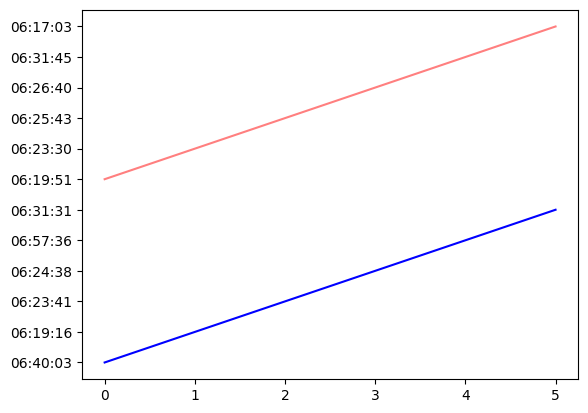

In [53]:
import matplotlib.pyplot as plt

num_of_samples = 200000

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

In [54]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [55]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [56]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [57]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

TypeError: Could not convert 06:40:0306:19:1606:23:4106:24:3806:57:3606:31:31 to numeric

In [ ]:
multi_variate_train_example = multi_variate_train_dataset[0]
multi_variate_train_example

# Define Model

In [ ]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
lags_sequence

In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
time_features

In [ ]:
# fix since data set already has this

from pandas.core.arrays.period import period_array

timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
dict(additional_features)

In [ ]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [ ]:
model.config.distribution_output

In [ ]:
# Define Transformations

from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [ ]:
# Define InstanceSplitter

from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
# Create DataLoaders

from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    k, v.shape, v.type()

In [ ]:
# Forward Pass

outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [ ]:
print("Loss:", outputs.loss.item())

# Model Training

In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 25
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

In [ ]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

# Model Evaluation

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())


In [ ]:
forecasts_[0].shape

In [ ]:
forecasts = np.vstack(forecasts_)

In [ ]:
# change to RMSE & Adjusted R^2

from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])
    
np.mean(mase_metrics)
np.mean(smape_metrics)

# Plot Results

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()

In [ ]:
plot(0, 344)